In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


from source import run_single_experiment, display_top_f1_scores

pd.options.display.max_rows = 999
plt.style.use('fivethirtyeight')

# Task: predict very low popularity trakcs on `Spotify` based on audio features

This is a notebook for the [blog post](http://blog.vaidasarmonas.tech/http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-2.html). The main idea is to investigate Machine Learning Design Patterns described in [this](https://www.oreilly.com/library/view/machine-learning-design/9781098115777/) book. This ispecific notebook is investigation of two design patterns - **Rebalancing** and **Ensembles**. 

Data was downloaded from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and you can find a description of this dataset there.

## Load data and quick EDA

In [2]:
data = pd.read_csv("./spotify_track_features_data.csv")

In [3]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
data_last_decade = data[data["year"] >= 2011]
print(f"Total tracks from the last decadelen: {len(data_last_decade)}")

Total tracks from the last decadelen: 19788


Split our dataset to train/test data before moving forward

In [5]:
AUDIO_FEATURES = [
    "valence",
    "acousticness",
    "danceability",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "mode",
    "speechiness",
    "tempo",
]
TARGET = "popularity"

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_last_decade[AUDIO_FEATURES], data_last_decade[TARGET], test_size=0.2, random_state=42)

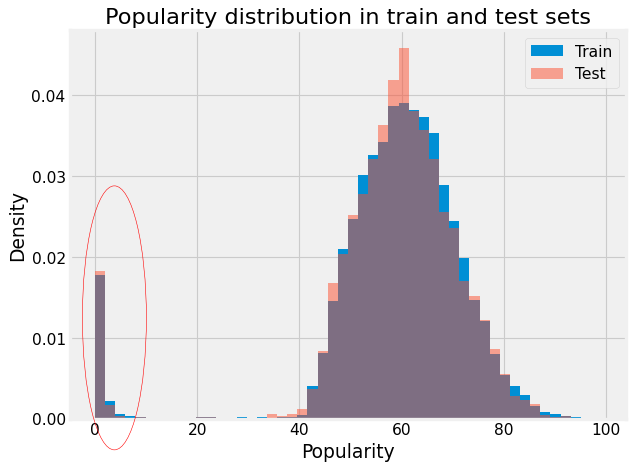

In [7]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_, bins, _ = plt.hist(y_train.to_list(), bins=50, density=True, label="Train")
_ = plt.hist(y_test.to_list(), bins=bins, alpha=0.5, density=True, label="Test")
e = Ellipse(xy=(0.15,0.28), width=0.1, height=0.55)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Popularity distribution in train and test sets")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [8]:
y_train.describe()

count    15830.000000
mean        58.889071
std         15.300208
min          0.000000
25%         54.000000
50%         61.000000
75%         67.000000
max         99.000000
Name: popularity, dtype: float64

In [9]:
y_test.describe()

count    3958.000000
mean       58.576554
std        15.135913
min         0.000000
25%        53.000000
50%        60.000000
75%        67.000000
max       100.000000
Name: popularity, dtype: float64

In [10]:
y_train[y_train <= 20].describe()

count    671.000000
mean       0.873323
std        2.506181
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       20.000000
Name: popularity, dtype: float64

In [11]:
y_train[y_train > 20].describe()

count    15159.000000
mean        61.457088
std          9.412284
min         21.000000
25%         55.000000
50%         61.000000
75%         68.000000
max         99.000000
Name: popularity, dtype: float64

In [12]:
# Preparing alternative targets for classification
y_train_low_pop = (y_train <= 20).astype(float)
y_test_low_pop = (y_test <= 20).astype(float)

print(f"Frequency of low popularity songs in train set: {y_train_low_pop.mean():.4f}")
print(f"Frequency of low popularity songs in test set: {y_test_low_pop.mean():.4f}")

Frequency of low popularity songs in train set: 0.0424
Frequency of low popularity songs in test set: 0.0414


In [13]:
y_train_low_pop.describe()

count    15830.000000
mean         0.042388
std          0.201479
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: popularity, dtype: float64

In [14]:
y_test_low_pop.describe()

count    3958.000000
mean        0.041435
std         0.199319
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: popularity, dtype: float64

# Modeling

Let us investigate different approaches to predict low popularity tracks. We will approach this as a highly imbalanced classification problem and will attempt to solve it with [Naive Classification](#naive_classifcation), [Different Class Weights](#class_weighing), [Random Undersampling](#random_udersampling), [NearMiss Undersampling](#nearmiss_undersampling), [SMOTE Oversampling](#SMOTE_oversampling), [ADASYN Oversampling](#ADASYN_oversampling), and [Ensemble](#ensemble).

You can skip to [results](#results) if you want to see which of the above approaches worked best in our case.

## Naive Classification <a id='naive_classification'>

In [15]:
naive_classifier = GradientBoostingClassifier().fit(X_train, y_train_low_pop)
preds = naive_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f1score = 2 * (precision * recall) / (precision + recall)

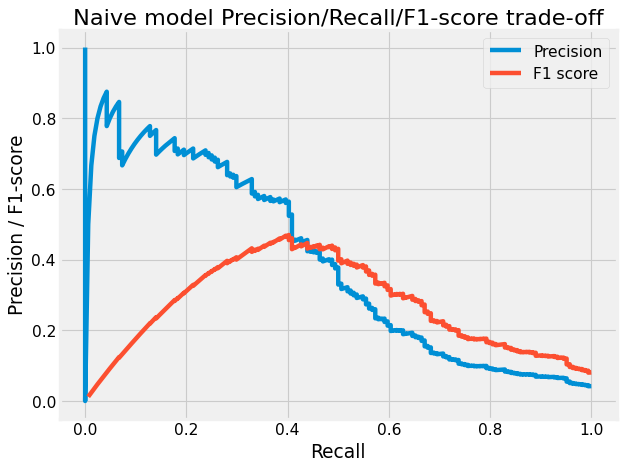

In [17]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(recall, precision, label='Precision')
_ = plt.plot(recall, f1score, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Naive model Precision/Recall/F1-score trade-off")
_ = plt.legend()

In [18]:
display_top_f1_scores(precision, recall, f1score, thresholds, recall_threshold=0.6)

,Precision,Recall,F1-score,Threshold
3287,0.214751,0.603659,0.316800,0.054707
3286,0.214286,0.603659,0.316294,0.054652
3285,0.213362,0.603659,0.315287,0.054623
3284,0.212903,0.603659,0.314785,0.054519
3283,0.212446,0.603659,0.314286,0.054497


If want to increase recall (to remove more undesired songs from the dataset), we end up with the model that has `f1-score` of `0.317`, with `precision` of `0.216`, `recall` of `0.604` at a threshold of `0.055`. Since the best model had the `recall` metric of `0.402`, selecting this sub-optimal model costs us `33%` in `f1-score` metric - a decrease from `0.470`.

## Different class weights <a id='class_weighing'>

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
class_weights_results = {}
for weight in tqdm(range(1, 15)):
    print(f"Running for minority weight input: {weight}")
    adjusted_weights = compute_sample_weight({0: 1, 1: weight}, y_train_low_pop)
    print(f"Actual weights - majority: {min(adjusted_weights)}; minority: {max(adjusted_weights)}")
    cls = GradientBoostingClassifier().fit(X_train, y_train_low_pop, adjusted_weights)
    preds = cls.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1score = 2 * (precision * recall) / (precision + recall)
    
    display_top_f1_scores(precision, recall, f1score, thresholds, recall_threshold=0.6)
    
    class_weights_results[weight] = {
        "cls": cls,
        "recall": recall,
        "precision": precision,
        "f1": f1score,
    }
    print()

  0%|          | 0/14 [00:00<?, ?it/s]

Running for minority weight input: 1
Actual weights - majority: 1.0; minority: 1.0


,Precision,Recall,F1-score,Threshold
3288,0.215217,0.603659,0.317308,0.054707
3287,0.214751,0.603659,0.316800,0.054652
3286,0.213823,0.603659,0.315789,0.054623
3285,0.213362,0.603659,0.315287,0.054519
3284,0.212903,0.603659,0.314785,0.054497



Running for minority weight input: 2
Actual weights - majority: 1.0; minority: 2.0


,Precision,Recall,F1-score,Threshold
3263,0.281250,0.603659,0.383721,0.124896
3262,0.280453,0.603659,0.382979,0.124783
3261,0.279661,0.603659,0.382239,0.124683
3260,0.278873,0.603659,0.381503,0.124346
3254,0.277008,0.609756,0.380952,0.122485



Running for minority weight input: 3
Actual weights - majority: 1.0; minority: 3.0


,Precision,Recall,F1-score,Threshold
3385,0.256477,0.603659,0.360000,0.167059
3384,0.255814,0.603659,0.359347,0.166356
3373,0.253133,0.615854,0.358792,0.163476
3383,0.255155,0.603659,0.358696,0.166234
3372,0.252500,0.615854,0.358156,0.162806



Running for minority weight input: 4
Actual weights - majority: 1.0; minority: 4.0


,Precision,Recall,F1-score,Threshold
3249,0.261214,0.603659,0.364641,0.212792
3248,0.260526,0.603659,0.363971,0.212030
3247,0.259843,0.603659,0.363303,0.211955
3246,0.259162,0.603659,0.362637,0.211885
3245,0.257812,0.603659,0.361314,0.211315



Running for minority weight input: 5
Actual weights - majority: 1.0; minority: 5.0


,Precision,Recall,F1-score,Threshold
3221,0.261780,0.609756,0.366300,0.246080
3220,0.261097,0.609756,0.365631,0.245622
3219,0.260417,0.609756,0.364964,0.245590
3218,0.259740,0.609756,0.364299,0.243935
3223,0.260526,0.603659,0.363971,0.246766



Running for minority weight input: 6
Actual weights - majority: 1.0; minority: 6.0


,Precision,Recall,F1-score,Threshold
3331,0.277311,0.603659,0.380038,0.288911
3330,0.276536,0.603659,0.379310,0.288830
3329,0.275766,0.603659,0.378585,0.288419
3328,0.275000,0.603659,0.377863,0.288118
3327,0.274238,0.603659,0.377143,0.287763



Running for minority weight input: 7
Actual weights - majority: 1.0; minority: 7.0


,Precision,Recall,F1-score,Threshold
3237,0.267568,0.603659,0.370787,0.320393
3236,0.266846,0.603659,0.370093,0.318622
3235,0.266129,0.603659,0.369403,0.318503
3234,0.265416,0.603659,0.368715,0.318179
3228,0.263852,0.609756,0.368324,0.314432



Running for minority weight input: 8
Actual weights - majority: 1.0; minority: 8.0


,Precision,Recall,F1-score,Threshold
3279,0.257143,0.603659,0.360656,0.339356
3278,0.256477,0.603659,0.360000,0.339008
3277,0.255814,0.603659,0.359347,0.337677
3276,0.255155,0.603659,0.358696,0.335361
3275,0.254499,0.603659,0.358047,0.335052



Running for minority weight input: 9
Actual weights - majority: 1.0; minority: 9.0


,Precision,Recall,F1-score,Threshold
3309,0.248139,0.609756,0.352734,0.352880
3308,0.247525,0.609756,0.352113,0.352544
3307,0.246914,0.609756,0.351494,0.352190
3312,0.247500,0.603659,0.351064,0.354423
3306,0.246305,0.609756,0.350877,0.352144



Running for minority weight input: 10
Actual weights - majority: 1.0; minority: 10.0


,Precision,Recall,F1-score,Threshold
3305,0.272973,0.615854,0.378277,0.391955
3315,0.275000,0.603659,0.377863,0.395334
3304,0.272237,0.615854,0.377570,0.391845
3314,0.274238,0.603659,0.377143,0.395170
3303,0.271505,0.615854,0.376866,0.390848



Running for minority weight input: 11
Actual weights - majority: 1.0; minority: 11.0


,Precision,Recall,F1-score,Threshold
3300,0.248120,0.603659,0.351687,0.398554
3299,0.247500,0.603659,0.351064,0.398333
3298,0.246883,0.603659,0.350442,0.397869
3297,0.246269,0.603659,0.349823,0.397532
3296,0.245658,0.603659,0.349206,0.397271



Running for minority weight input: 12
Actual weights - majority: 1.0; minority: 12.0


,Precision,Recall,F1-score,Threshold
3477,0.275766,0.603659,0.378585,0.446782
3476,0.275000,0.603659,0.377863,0.446481
3475,0.274238,0.603659,0.377143,0.446202
3474,0.273481,0.603659,0.376426,0.444672
3473,0.272727,0.603659,0.375712,0.444424



Running for minority weight input: 13
Actual weights - majority: 1.0; minority: 13.0


,Precision,Recall,F1-score,Threshold
3356,0.255102,0.609756,0.359712,0.450148
3355,0.254453,0.609756,0.359066,0.450016
3354,0.253807,0.609756,0.358423,0.449648
3359,0.254499,0.603659,0.358047,0.453000
3353,0.253165,0.609756,0.357782,0.448798



Running for minority weight input: 14
Actual weights - majority: 1.0; minority: 14.0


,Precision,Recall,F1-score,Threshold
3219,0.236659,0.621951,0.342857,0.449017
3218,0.235566,0.621951,0.341709,0.448419
3217,0.235023,0.621951,0.341137,0.447774
3227,0.236407,0.609756,0.340716,0.453295
3221,0.235431,0.615854,0.340641,0.449245


We made an improvement with the weighting of the minority class variables selecting weight as `6-to-1`.
Results of the best threshold (`0.289`): Precision - `0.277`; Recall - `0.604`; F1 - `0.379`. Again, because we require model with at least `0.6` recall, it is not optimal model in terms of `f1-score`. We have a drop of `22.5%` in f1-score comapred to the optimal model.

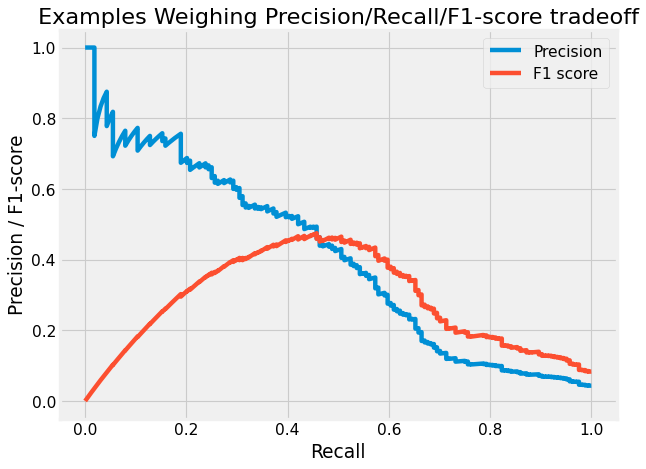

In [30]:
plot_precision = class_weights_results[6]["precision"]
plot_recall = class_weights_results[6]["recall"]
plot_f1 = class_weights_results[6]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Examples Weighing Precision/Recall/F1-score tradeoff")
_ = plt.legend()

## Random Undersampling <a id='random_udersampling'>

In [22]:
from imblearn.under_sampling import RandomUnderSampler

In [23]:
random_sample_models = {}
for sampling_strategy in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for sampling strategy: {sampling_strategy}")
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(rus, X_train, y_train_low_pop, X_test, y_test_low_pop, recall_threshold=0.6)
    random_sample_models[sampling_strategy] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
3435,0.235154,0.603659,0.338462,0.126178
3434,0.234597,0.603659,0.337884,0.126159
3428,0.233645,0.609756,0.337838,0.124871
3433,0.234043,0.603659,0.337308,0.125719
3427,0.233100,0.609756,0.337268,0.124514



Running for sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
3458,0.300300,0.609756,0.402414,0.211853
3457,0.299401,0.609756,0.401606,0.210824
3456,0.298507,0.609756,0.400802,0.210711
3455,0.297619,0.609756,0.400000,0.210699
3454,0.296736,0.609756,0.399202,0.210451



Running for sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
3340,0.274238,0.603659,0.377143,0.258857
3339,0.273481,0.603659,0.376426,0.258563
3328,0.270777,0.615854,0.376164,0.254013
3333,0.271739,0.609756,0.375940,0.256372
3338,0.272727,0.603659,0.375712,0.258560



Running for sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
3362,0.269755,0.603659,0.372881,0.308338
3361,0.269022,0.603659,0.372180,0.307431
3360,0.268293,0.603659,0.371482,0.307151
3359,0.267568,0.603659,0.370787,0.307034
3358,0.266846,0.603659,0.370093,0.306662



Running for sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
3231,0.265092,0.615854,0.370642,0.345699
3230,0.264398,0.615854,0.369963,0.345642
3240,0.266129,0.603659,0.369403,0.350355
3229,0.263708,0.615854,0.369287,0.345576
3239,0.265416,0.603659,0.368715,0.350007



Running for sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
3228,0.262467,0.609756,0.366972,0.389300
3227,0.261780,0.609756,0.366300,0.389194
3232,0.262599,0.603659,0.365989,0.392924
3226,0.261097,0.609756,0.365631,0.388300
3231,0.261905,0.603659,0.365314,0.391922



Running for sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
3357,0.275000,0.603659,0.377863,0.441212
3351,0.273224,0.609756,0.377358,0.439864
3356,0.274238,0.603659,0.377143,0.440902
3350,0.272480,0.609756,0.376648,0.439603
3355,0.273481,0.603659,0.376426,0.440843



Running for sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
3192,0.249377,0.609756,0.353982,0.442201
3191,0.248756,0.609756,0.353357,0.442118
3190,0.248139,0.609756,0.352734,0.441357
3189,0.247525,0.609756,0.352113,0.440831
3188,0.246914,0.609756,0.351494,0.440418



Running for sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3153,0.257143,0.603659,0.360656,0.477707
3152,0.256477,0.603659,0.360000,0.477187
3151,0.255814,0.603659,0.359347,0.476264
3150,0.255155,0.603659,0.358696,0.475996
3149,0.254499,0.603659,0.358047,0.474852


The best model with at least 0.6 recall is produced by randomly undersampling majority class to 15/85. THe results are: `precision` - 0.300; `recall` - 0.610; `f1-score` - 0.402. Threshold - 0.212. The drop in f1-score is 17%.

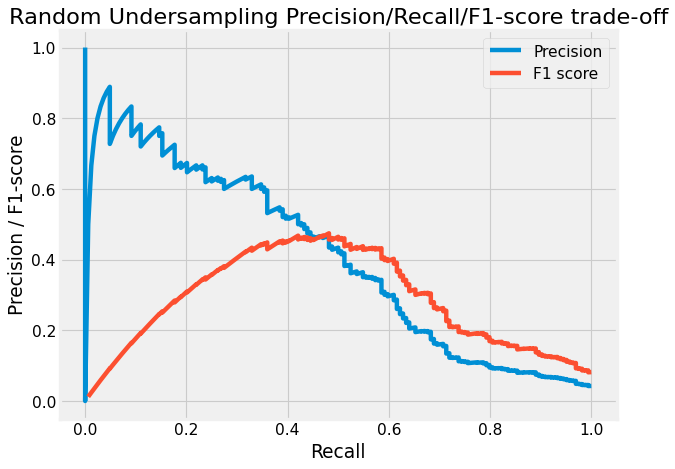

In [31]:
plot_precision = random_sample_models[0.15]["precision"]
plot_recall = random_sample_models[0.15]["recall"]
plot_f1 = random_sample_models[0.15]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Random Undersampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Smart undersampling - NearMiss <a id='nearmiss_undersampling'>

In [24]:
from imblearn.under_sampling import NearMiss

In [25]:
near_miss_models = {}
for near_miss_version in tqdm(range(1, 4)):
    for sampling_strategy in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
        print(f"Running for NearMiss version: {near_miss_version} & sampling strategy: {sampling_strategy}")
        nm = NearMiss(sampling_strategy=sampling_strategy, version=near_miss_version)
        cls, precision, recall, f1 = run_single_experiment(nm, X_train, y_train_low_pop, X_test, y_test_low_pop, recall_threshold=0.6)
        near_miss_models[f"{near_miss_version}_{sampling_strategy}"] = {
            "cls": cls,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
        print()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 1 & sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
3066,0.141026,0.603659,0.228637,0.144173
3065,0.140825,0.603659,0.228374,0.144066
3064,0.140625,0.603659,0.228111,0.143572
3063,0.140426,0.603659,0.227848,0.143532
3062,0.140227,0.603659,0.227586,0.143284



Running for NearMiss version: 1 & sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
2819,0.134877,0.603659,0.220490,0.272391
2818,0.134694,0.603659,0.220245,0.272295
2817,0.134511,0.603659,0.220000,0.272171
2816,0.134328,0.603659,0.219756,0.271059
2815,0.134146,0.603659,0.219512,0.270862



Running for NearMiss version: 1 & sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
2720,0.108079,0.603659,0.183333,0.317373
2719,0.107961,0.603659,0.183164,0.317228
2718,0.107843,0.603659,0.182994,0.317203
2717,0.107726,0.603659,0.182825,0.316207
2716,0.107609,0.603659,0.182657,0.315736



Running for NearMiss version: 1 & sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
2877,0.104384,0.609756,0.178253,0.378860
2876,0.104275,0.609756,0.178094,0.378747
2875,0.104167,0.609756,0.177936,0.377501
2874,0.104058,0.609756,0.177778,0.377285
2873,0.103950,0.609756,0.177620,0.377025



Running for NearMiss version: 1 & sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
2734,0.086995,0.603659,0.152074,0.377126
2733,0.086918,0.603659,0.151957,0.376946
2732,0.086842,0.603659,0.151840,0.376813
2731,0.086766,0.603659,0.151724,0.376192
2730,0.086690,0.603659,0.151608,0.376063



Running for NearMiss version: 1 & sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
2597,0.076982,0.609756,0.136705,0.367079
2596,0.076923,0.609756,0.136612,0.366769
2595,0.076864,0.609756,0.136519,0.366760
2609,0.076923,0.603659,0.136458,0.371888
2594,0.076805,0.609756,0.136426,0.366110



Running for NearMiss version: 1 & sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
2681,0.082855,0.615854,0.146059,0.438280
2680,0.082787,0.615854,0.145954,0.438081
2679,0.082719,0.615854,0.145848,0.437440
2678,0.082651,0.615854,0.145743,0.437176
2677,0.082584,0.615854,0.145638,0.436512



Running for NearMiss version: 1 & sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
2604,0.076566,0.603659,0.135896,0.445704
2603,0.076507,0.603659,0.135802,0.445451
2602,0.076448,0.603659,0.135709,0.445195
2601,0.076389,0.603659,0.135616,0.444508
2600,0.076330,0.603659,0.135524,0.444500



Running for NearMiss version: 1 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
2651,0.078571,0.603659,0.139045,0.496509
2650,0.078509,0.603659,0.138947,0.496073
2649,0.078447,0.603659,0.138850,0.495983
2648,0.078385,0.603659,0.138753,0.495416
2647,0.078323,0.603659,0.138655,0.494807


  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 2 & sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
1023,0.058948,0.847561,0.110230,0.056270
1022,0.058923,0.847561,0.110186,0.056073
1021,0.058898,0.847561,0.110143,0.056019
1020,0.058873,0.847561,0.110099,0.055582
1019,0.058848,0.847561,0.110055,0.055564



Running for NearMiss version: 2 & sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
458,0.049076,0.939024,0.093277,0.037113
436,0.049051,0.945122,0.093261,0.035873
457,0.049060,0.939024,0.093249,0.037085
705,0.049271,0.865854,0.093237,0.060254
435,0.049035,0.945122,0.093233,0.035871



Running for NearMiss version: 2 & sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
490,0.046732,0.902439,0.088862,0.058173
489,0.046717,0.902439,0.088836,0.058053
488,0.046702,0.902439,0.088809,0.057900
487,0.046688,0.902439,0.088782,0.057787
486,0.046673,0.902439,0.088756,0.057663



Running for NearMiss version: 2 & sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
422,0.045908,0.926829,0.087482,0.075259
421,0.045894,0.926829,0.087457,0.074535
420,0.045880,0.926829,0.087432,0.072610
419,0.045866,0.926829,0.087407,0.071637
396,0.045850,0.932927,0.087404,0.063431



Running for NearMiss version: 2 & sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
425,0.045628,0.945122,0.087054,0.104785
380,0.045600,0.957317,0.087053,0.066960
424,0.045615,0.945122,0.087030,0.104626
379,0.045587,0.957317,0.087029,0.066935
423,0.045602,0.945122,0.087005,0.100163



Running for NearMiss version: 2 & sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
377,0.045298,0.963415,0.086528,0.119332
376,0.045285,0.963415,0.086504,0.117058
330,0.045249,0.975610,0.086486,0.076006
375,0.045272,0.963415,0.086481,0.117055
329,0.045236,0.975610,0.086463,0.075827



Running for NearMiss version: 2 & sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
1935,0.059941,0.615854,0.109248,0.983092
1934,0.059905,0.615854,0.109189,0.983080
1933,0.059870,0.615854,0.109130,0.983049
1932,0.059834,0.615854,0.109071,0.983010
1931,0.059799,0.615854,0.109012,0.982978



Running for NearMiss version: 2 & sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
1915,0.056805,0.615854,0.104016,0.983640
1914,0.056773,0.615854,0.103963,0.983629
1913,0.056742,0.615854,0.103909,0.983623
1912,0.056710,0.615854,0.103856,0.983621
1949,0.056799,0.603659,0.103828,0.984044



Running for NearMiss version: 2 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
2128,0.068641,0.621951,0.123636,0.987130
2127,0.068548,0.621951,0.123487,0.987125
2126,0.068502,0.621951,0.123412,0.987115
2125,0.068456,0.621951,0.123337,0.987109
2124,0.068410,0.621951,0.123263,0.987108


  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 3 & sampling strategy: 0.1


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2996,0.118705,0.603659,0.198397,0.318543
2995,0.118563,0.603659,0.198198,0.318398
2994,0.118421,0.603659,0.198000,0.318379
2993,0.118280,0.603659,0.197802,0.318176
2992,0.118138,0.603659,0.197605,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.15


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2995,0.118563,0.603659,0.198198,0.318543
2994,0.118421,0.603659,0.198000,0.318398
2993,0.118280,0.603659,0.197802,0.318379
2992,0.118138,0.603659,0.197605,0.318176
2991,0.117998,0.603659,0.197408,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.2


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2995,0.118563,0.603659,0.198198,0.318543
2994,0.118421,0.603659,0.198000,0.318398
2993,0.118280,0.603659,0.197802,0.318379
2992,0.118138,0.603659,0.197605,0.318176
2991,0.117998,0.603659,0.197408,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.25


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2993,0.118280,0.603659,0.197802,0.318543
2992,0.118138,0.603659,0.197605,0.318398
2991,0.117998,0.603659,0.197408,0.318379
2990,0.117857,0.603659,0.197211,0.318176
2989,0.117717,0.603659,0.197015,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.3


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2997,0.118705,0.603659,0.198397,0.318543
2996,0.118563,0.603659,0.198198,0.318398
2995,0.118421,0.603659,0.198000,0.318379
2994,0.118280,0.603659,0.197802,0.318176
2993,0.118138,0.603659,0.197605,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.35


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2994,0.118421,0.603659,0.198000,0.318543
2993,0.118280,0.603659,0.197802,0.318398
2992,0.118138,0.603659,0.197605,0.318379
2991,0.117998,0.603659,0.197408,0.318176
2990,0.117857,0.603659,0.197211,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.4


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2996,0.118705,0.603659,0.198397,0.318543
2995,0.118563,0.603659,0.198198,0.318398
2994,0.118421,0.603659,0.198000,0.318379
2993,0.118280,0.603659,0.197802,0.318176
2992,0.118138,0.603659,0.197605,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.45


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
2995,0.118563,0.603659,0.198198,0.318543
2994,0.118421,0.603659,0.198000,0.318398
2993,0.118280,0.603659,0.197802,0.318379
2992,0.118138,0.603659,0.197605,0.318176
2991,0.117998,0.603659,0.197408,0.317970



Running for NearMiss version: 3 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3251,0.169205,0.609756,0.264901,0.385123
3250,0.168919,0.609756,0.264550,0.384704
3257,0.169231,0.603659,0.264352,0.388052
3249,0.168634,0.609756,0.264201,0.384532
3256,0.168942,0.603659,0.264000,0.388016


The best moddel was trained on the data that was "balanced" (50/50) and used algorithm version 3.
Results of the best threshold (`0.385`): Precision - `0.169`; Recall - `0.610`; F1 - `0.265`. Drop in f1-scire is 34%.

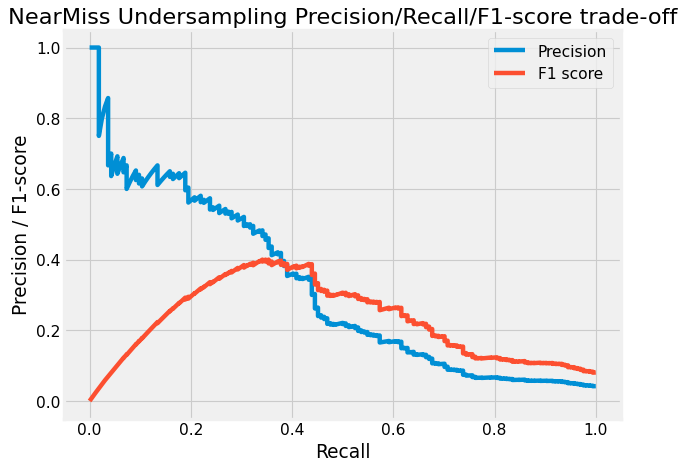

In [26]:
plot_precision = near_miss_models["3_0.5"]["precision"]
plot_recall = near_miss_models["3_0.5"]["recall"]
plot_f1 = near_miss_models["3_0.5"]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("NearMiss Undersampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Oversampling - SMOTE <a id='SMOTE_oversampling'>

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
smote_models = {}
for smote_ratio in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for SMOTE ratio: {smote_ratio}")
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(smote, X_train, y_train_low_pop, X_test, y_test_low_pop, recall_threshold=0.6)
    smote_models[smote_ratio] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for SMOTE ratio: 0.1


,Precision,Recall,F1-score,Threshold
3171,0.183824,0.609756,0.282486,0.093475
3170,0.183486,0.609756,0.282087,0.093398
3162,0.182640,0.615854,0.281729,0.092700
3169,0.183150,0.609756,0.281690,0.093317
3176,0.183673,0.603659,0.281650,0.094372



Running for SMOTE ratio: 0.15


,Precision,Recall,F1-score,Threshold
3311,0.210638,0.603659,0.312303,0.148112
3310,0.210191,0.603659,0.311811,0.148080
3309,0.209746,0.603659,0.311321,0.147897
3308,0.209302,0.603659,0.310832,0.147837
3307,0.208861,0.603659,0.310345,0.147123



Running for SMOTE ratio: 0.2


,Precision,Recall,F1-score,Threshold
3246,0.182994,0.603659,0.280851,0.164930
3245,0.182657,0.603659,0.280453,0.164913
3244,0.182320,0.603659,0.280057,0.164520
3243,0.181985,0.603659,0.279661,0.163591
3242,0.181651,0.603659,0.279267,0.163512



Running for SMOTE ratio: 0.25


,Precision,Recall,F1-score,Threshold
3121,0.172474,0.603659,0.268293,0.182938
3120,0.172174,0.603659,0.267930,0.182762
3119,0.171875,0.603659,0.267568,0.182464
3118,0.171577,0.603659,0.267206,0.181684
3117,0.171280,0.603659,0.266846,0.181617



Running for SMOTE ratio: 0.3


,Precision,Recall,F1-score,Threshold
3046,0.170690,0.603659,0.266129,0.216694
3045,0.170396,0.603659,0.265772,0.216589
3044,0.170103,0.603659,0.265416,0.216589
3043,0.169811,0.603659,0.265060,0.215684
3042,0.169521,0.603659,0.264706,0.215665



Running for SMOTE ratio: 0.35


,Precision,Recall,F1-score,Threshold
2949,0.178571,0.609756,0.276243,0.237442
2948,0.178253,0.609756,0.275862,0.235678
2947,0.177936,0.609756,0.275482,0.234209
2946,0.177620,0.609756,0.275103,0.233028
2953,0.178058,0.603659,0.275000,0.238901



Running for SMOTE ratio: 0.4


,Precision,Recall,F1-score,Threshold
3229,0.185741,0.603659,0.284075,0.272842
3228,0.185393,0.603659,0.283668,0.272565
3227,0.185047,0.603659,0.283262,0.272470
3226,0.184701,0.603659,0.282857,0.271211
3225,0.184358,0.603659,0.282454,0.271188



Running for SMOTE ratio: 0.45


,Precision,Recall,F1-score,Threshold
3059,0.145743,0.615854,0.235706,0.240076
3042,0.145070,0.628049,0.235698,0.234811
3033,0.144645,0.634146,0.235561,0.231722
3058,0.145533,0.615854,0.235431,0.239938
3041,0.144866,0.628049,0.235429,0.234713



Running for SMOTE ratio: 0.5


,Precision,Recall,F1-score,Threshold
3264,0.178700,0.603659,0.275766,0.304654
3263,0.178378,0.603659,0.275382,0.302798
3262,0.178058,0.603659,0.275000,0.301932
3261,0.177738,0.603659,0.274619,0.301457
3260,0.177419,0.603659,0.274238,0.301130


The best model was trained on the data that was "balanced" to the `15/85` mark.
Results of the best threshold (`0.148`): Precision - `0.211`; Recall - `0.604`; f1-score - `0.312`, 29% drop in f1-score.

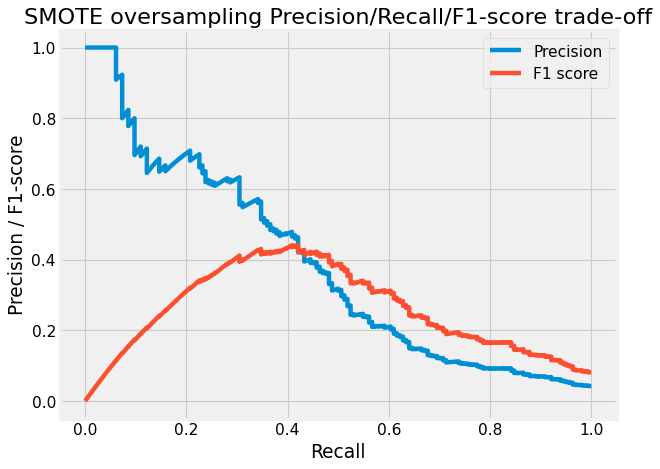

In [29]:
plot_precision = smote_models[0.15]["precision"]
plot_recall = smote_models[0.15]["recall"]
plot_f1 = smote_models[0.15]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("SMOTE oversampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Oversampling - ADASYN <a id='ADASYN_oversampling'>

In [32]:
from imblearn.over_sampling import ADASYN

In [33]:
adasyn_models = {}
for adasyn_ratio in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for ADASYN ratio: {adasyn_ratio}")
    adasyn = ADASYN(sampling_strategy=adasyn_ratio, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(adasyn, X_train, y_train_low_pop, X_test, y_test_low_pop, recall_threshold=0.6)
    adasyn_models[adasyn_ratio] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for ADASYN ratio: 0.1


,Precision,Recall,F1-score,Threshold
3151,0.198428,0.615854,0.300149,0.106836
3150,0.198039,0.615854,0.299703,0.106775
3156,0.198413,0.609756,0.299401,0.107678
3149,0.197652,0.615854,0.299259,0.106337
3155,0.198020,0.609756,0.298954,0.107475



Running for ADASYN ratio: 0.15


,Precision,Recall,F1-score,Threshold
3225,0.185185,0.609756,0.284091,0.137170
3224,0.184843,0.609756,0.283688,0.137147
3223,0.184502,0.609756,0.283286,0.137106
3230,0.185047,0.603659,0.283262,0.137807
3222,0.184162,0.609756,0.282885,0.137099



Running for ADASYN ratio: 0.2


,Precision,Recall,F1-score,Threshold
3154,0.165829,0.603659,0.260184,0.159257
3153,0.165552,0.603659,0.259843,0.159237
3152,0.165000,0.603659,0.259162,0.158898
3151,0.164725,0.603659,0.258824,0.158813
3150,0.164452,0.603659,0.258486,0.158576



Running for ADASYN ratio: 0.25


,Precision,Recall,F1-score,Threshold
3225,0.192308,0.609756,0.292398,0.211413
3224,0.191939,0.609756,0.291971,0.211406
3223,0.191571,0.609756,0.291545,0.210603
3222,0.191205,0.609756,0.291121,0.210369
3221,0.190840,0.609756,0.290698,0.210282



Running for ADASYN ratio: 0.3


,Precision,Recall,F1-score,Threshold
3187,0.168919,0.609756,0.264550,0.216964
3186,0.168634,0.609756,0.264201,0.216675
3185,0.168350,0.609756,0.263852,0.216629
3184,0.168067,0.609756,0.263505,0.216392
3191,0.168367,0.603659,0.263298,0.220756



Running for ADASYN ratio: 0.35


,Precision,Recall,F1-score,Threshold
3135,0.151145,0.603659,0.241758,0.214353
3134,0.150915,0.603659,0.241463,0.214352
3133,0.150685,0.603659,0.241169,0.214195
3132,0.150456,0.603659,0.240876,0.213902
3131,0.150228,0.603659,0.240583,0.213838



Running for ADASYN ratio: 0.4


,Precision,Recall,F1-score,Threshold
3156,0.147761,0.603659,0.237410,0.243236
3155,0.147541,0.603659,0.237126,0.242909
3154,0.147321,0.603659,0.236842,0.242772
3153,0.147103,0.603659,0.236559,0.242507
3152,0.146884,0.603659,0.236277,0.241719



Running for ADASYN ratio: 0.45


,Precision,Recall,F1-score,Threshold
3185,0.147761,0.603659,0.237410,0.261233
3184,0.147541,0.603659,0.237126,0.261180
3183,0.147321,0.603659,0.236842,0.261126
3182,0.147103,0.603659,0.236559,0.260335
3181,0.146884,0.603659,0.236277,0.260089



Running for ADASYN ratio: 0.5


,Precision,Recall,F1-score,Threshold
3162,0.153251,0.603659,0.244444,0.285210
3161,0.153014,0.603659,0.244143,0.284884
3160,0.152778,0.603659,0.243842,0.283903
3159,0.152542,0.603659,0.243542,0.283799
3158,0.152308,0.603659,0.243243,0.283543


The best model was trained on the data that was "balanced" to the `10/90` mark. Results are quite similar this time (not like with the best f1-score model). Results of the best threshold (`0.107`): Precision - `0.198`; Recall - `0.616`; F1 - `0.300` a drop of 27%.

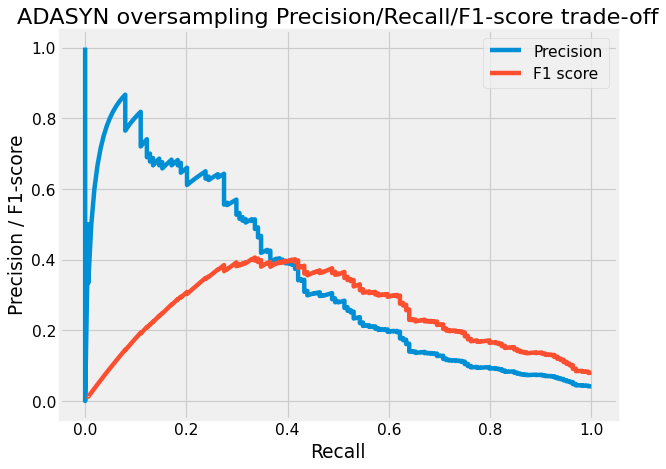

In [34]:
plot_precision = adasyn_models[0.1]["precision"]
plot_recall = adasyn_models[0.1]["recall"]
plot_f1 = adasyn_models[0.1]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("ADASYN oversampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Ensemble <a id='ensemble'>

In [35]:
from imblearn.ensemble import BalancedBaggingClassifier

In [36]:
ensemble_models = {}
for n_cls in tqdm(range(10, 51, 5)):
    print(f"Running for Ensemble with {n_cls} classifiers")
    cls = BalancedBaggingClassifier(
        n_estimators=n_cls,
        replacement=True,
        random_state=42
    )
    cls.fit(X_train, y_train_low_pop)
    preds = cls.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1score = 2 * (precision * recall) / (precision + recall)
    display_top_f1_scores(precision, recall, f1score, thresholds, recall_threshold=0.6)
    
    ensemble_models[n_cls] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1score,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for Ensemble with 10 classifiers


,Precision,Recall,F1-score,Threshold
13,0.221739,0.621951,0.326923,0.600000
12,0.154583,0.689024,0.252514,0.500000
11,0.154161,0.689024,0.251951,0.466667
10,0.115837,0.780488,0.201734,0.400000
9,0.115628,0.780488,0.201416,0.366667



Running for Ensemble with 15 classifiers


,Precision,Recall,F1-score,Threshold
21,0.250000,0.603659,0.353571,0.600000
20,0.249370,0.603659,0.352941,0.577778
19,0.194444,0.640244,0.298295,0.533333
18,0.154653,0.719512,0.254585,0.466667
17,0.154248,0.719512,0.254037,0.444444



Running for Ensemble with 20 classifiers


,Precision,Recall,F1-score,Threshold
35,0.273973,0.609756,0.378072,0.600
34,0.273224,0.609756,0.377358,0.590
33,0.225108,0.634146,0.332268,0.550
32,0.224622,0.634146,0.331738,0.525
31,0.179321,0.676829,0.283525,0.500



Running for Ensemble with 25 classifiers


,Precision,Recall,F1-score,Threshold
38,0.289855,0.609756,0.392927,0.600
37,0.244131,0.634146,0.352542,0.560
36,0.243560,0.634146,0.351946,0.552
35,0.209302,0.658537,0.317647,0.520
34,0.208897,0.658537,0.317181,0.500



Running for Ensemble with 30 classifiers


,Precision,Recall,F1-score,Threshold
42,0.306748,0.609756,0.408163,0.600000
41,0.264935,0.621951,0.371585,0.566667
40,0.229759,0.640244,0.338164,0.533333
39,0.205556,0.676829,0.315341,0.500000
38,0.205176,0.676829,0.314894,0.493333



Running for Ensemble with 35 classifiers


,Precision,Recall,F1-score,Threshold
48,0.311321,0.603659,0.410788,0.600000
47,0.310345,0.603659,0.409938,0.590476
46,0.282123,0.615854,0.386973,0.571429
45,0.251208,0.634146,0.359862,0.542857
44,0.250602,0.634146,0.359240,0.528571



Running for Ensemble with 40 classifiers


,Precision,Recall,F1-score,Threshold
53,0.318328,0.603659,0.416842,0.600000
52,0.288184,0.609756,0.391389,0.575000
51,0.287356,0.609756,0.390625,0.566667
50,0.263427,0.628049,0.371171,0.550000
49,0.240909,0.646341,0.350993,0.525000



Running for Ensemble with 45 classifiers


,Precision,Recall,F1-score,Threshold
61,0.280654,0.628049,0.387947,0.555556
60,0.279891,0.628049,0.387218,0.548148
59,0.251208,0.634146,0.359862,0.533333
58,0.234136,0.652439,0.344605,0.511111
57,0.233624,0.652439,0.344051,0.500000



Running for Ensemble with 50 classifiers


,Precision,Recall,F1-score,Threshold
65,0.275956,0.615854,0.381132,0.560000
64,0.275204,0.615854,0.380414,0.553333
63,0.274457,0.615854,0.379699,0.550000
62,0.265152,0.640244,0.375000,0.540000
61,0.243678,0.646341,0.353923,0.520000


The best ensemble contained `40` models in it. Results of the best threshold (`0.600`): Precision - `0.318`; Recall - `0.604`; F1 - `0.417`, a drop of 12%.

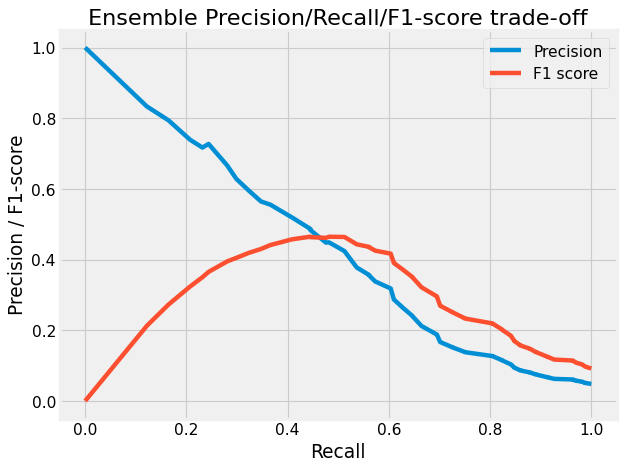

In [37]:
plot_precision = ensemble_models[40]["precision"]
plot_recall = ensemble_models[40]["recall"]
plot_f1 = ensemble_models[40]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Ensemble Precision/Recall/F1-score trade-off")
_ = plt.legend()

# Results overview <a id='results'>

Bellow are the best performing models (with their respective thresholds) from each approach:

| Approach | Precision | Recall | F1-Score | F1-Score drop | Notes |
| -------- | --------- | ------ | -------- | ------------- | ----- |
| Ensemble | 0.318 | 0.604 | 0.417 | 12% | Best performing ensemble was with 40 models; threshold - 0.600 |
| Random undersampling | 0.300 | 0.610 | 0.402 | 17% | Best performing undersampling to 15/85; threshold - 0.212 |
| Weighting training examples | 0.277 | 0.604 | 0.380 | 23% | Best performing weighting at 6-to-1; threshold - 0.289 |
| Naive | 0.216 | 0.604 | 0.317 | 33% | Threshold - 0.055 |
| SMOTE oversampling | 0.211 | 0.604 | 0.312 | 29% | Best performing oversampling at 15/85; threshold - 0.148 |
| ADASYN oversampling | 0.198 | 0.616 | 0.300 | 27% | Best performing oversampling at 10/90; threshold - 0.107 |
| NearMiss undersampling | 0.169 | 0.610 | 0.265 | 34% | Best performing undersampling was done with version 3 to 50/50; threshold - 0.319 |


## "Cleaned" training dataset

### With Class Weights Model

In [38]:
train_preds =  ensemble_models[40]["cls"].predict_proba(X_train)[:, 1]
train_preds_remain = (train_preds < 0.6000)

In [39]:
y_train_cleaned = y_train.loc[train_preds_remain]


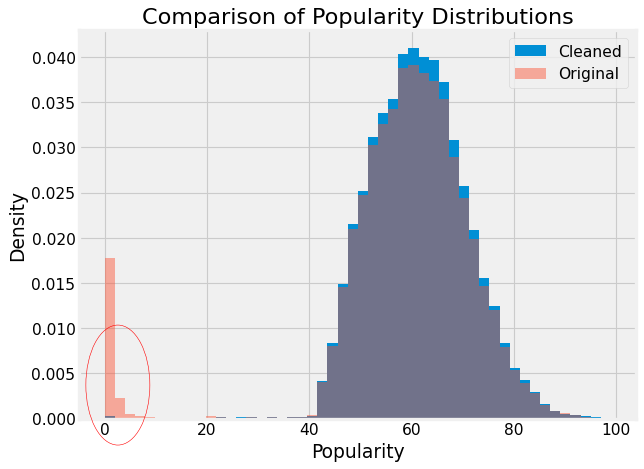

In [40]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_1, bins, _ = plt.hist(y_train_cleaned.to_list(), bins=50, density=True, label="Cleaned")
_11, _, _ = plt.hist(y_train.to_list(), bins=bins, alpha=0.45, density=True, label="Original")
e = Ellipse(xy=(0.14,0.14), width=0.1, height=0.25)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Comparison of Popularity Distributions")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [41]:
print(f"We have {(1 - (_1[0]/_11[0]))*100:0.2f} percent fewer low scores in `cleaned` dataset")

We have 98.24 percent fewer low scores in `cleaned` dataset
